## Imports

In [110]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [111]:
PATH = "../datasets/filtered-data/"

movies = pd.read_csv(f"{PATH}filtered_movies.csv")
actors = pd.read_csv(f"{PATH}actors_actresses.csv")
crew = pd.read_csv(f"{PATH}filtered_crew.csv")
ratings = pd.read_csv(f"{PATH}filtered_ratings.csv")
names = pd.read_csv(f"{PATH}filtered_name_basics.csv")

## Netttoyer les donnees

In [112]:
print(actors.shape)

# Compter le nombre de films par acteur
actor_film_counts = actors['nconst'].value_counts()

# Filtrer les acteurs ayant joué dans plus de 1 film
actors = actors[actors['nconst'].isin(actor_film_counts[actor_film_counts > 10].index)]
print(actors.shape)

(416137, 4)
(133834, 4)


In [113]:
# Nettoyage des données
movies = movies.dropna(subset=['genres'])
movies['genres'] = movies['genres'].apply(lambda x: x.split(','))
movies = movies[movies["numVotes"] >= 10000]
# movies = movies[movies["startYear"] >= 2000]

# Merge des datasets
actors = actors.merge(movies[['tconst', 'primaryTitle', 'genres']], on='tconst')
print(actors.shape)

(51811, 6)


In [114]:
# Pré-calcul des listes d'acteurs pour chaque film
movie_to_actors = defaultdict(list)
for _, row in actors.iterrows():
    movie_to_actors[row['tconst']].append(row['nconst'])

## Creation du graph de cooccurence

In [115]:
# Création des graphes de co-occurrence des acteurs par genre optimisée
def create_cooccurrence_graph(data):
    genre_graphs = defaultdict(nx.Graph)

    for _, row in data.iterrows():
        for genre in row['genres']:
            actor_list = movie_to_actors[row['tconst']]
            for i in range(len(actor_list)):
                for j in range(i + 1, len(actor_list)):
                    actor_i, actor_j = actor_list[i], actor_list[j]
                    if actor_i != actor_j:
                        if not genre_graphs[genre].has_edge(actor_i, actor_j):
                            genre_graphs[genre].add_edge(actor_i, actor_j, weight=0)
                        genre_graphs[genre][actor_i][actor_j]['weight'] += 1

    return genre_graphs

# Créer les graphes par genre
genre_graphs = create_cooccurrence_graph(movies)

genre_actor_counts = {genre: len(graph.nodes()) for genre, graph in genre_graphs.items()}
top_genres = sorted(genre_actor_counts, key=genre_actor_counts.get, reverse=True)[:10]
genre_graphs = {genre: graph for genre, graph in genre_graphs.items() if genre in top_genres}

## Analyse de la structure des graphs par genre

In [116]:
# Affichage des statistiques des graphes
for genre, graph in genre_graphs.items():
    print(f"Genre: {genre}")
    print(f"Nombre d'acteurs: {graph.number_of_nodes()}")
    print(f"Nombre d'arêtes: {graph.number_of_edges()}")
    print(f"Degré moyen: {np.mean(list(dict(graph.degree()).values()))}")
    print(f"Clustering moyen: {nx.average_clustering(graph)}")
    print()

Genre: Drama
Nombre d'acteurs: 5320
Nombre d'arêtes: 65655
Degré moyen: 24.68233082706767
Clustering moyen: 0.417727329485839

Genre: Romance
Nombre d'acteurs: 3488
Nombre d'arêtes: 21434
Degré moyen: 12.2901376146789
Clustering moyen: 0.6147148948401929

Genre: Comedy
Nombre d'acteurs: 4349
Nombre d'arêtes: 45187
Degré moyen: 20.780409289491836
Clustering moyen: 0.4951460855914941

Genre: Thriller
Nombre d'acteurs: 3221
Nombre d'arêtes: 18486
Degré moyen: 11.47842285004657
Clustering moyen: 0.6282987450165922

Genre: Action
Nombre d'acteurs: 3981
Nombre d'arêtes: 35445
Degré moyen: 17.80708364732479
Clustering moyen: 0.5418283791368046

Genre: Crime
Nombre d'acteurs: 3905
Nombre d'arêtes: 28262
Degré moyen: 14.474775928297055
Clustering moyen: 0.5850478919163613

Genre: Horror
Nombre d'acteurs: 2274
Nombre d'arêtes: 7813
Degré moyen: 6.871591908531222
Clustering moyen: 0.6877059374447774

Genre: Adventure
Nombre d'acteurs: 3304
Nombre d'arêtes: 23661
Degré moyen: 14.322639225181598
Cl

### Plot le graph pour un genre

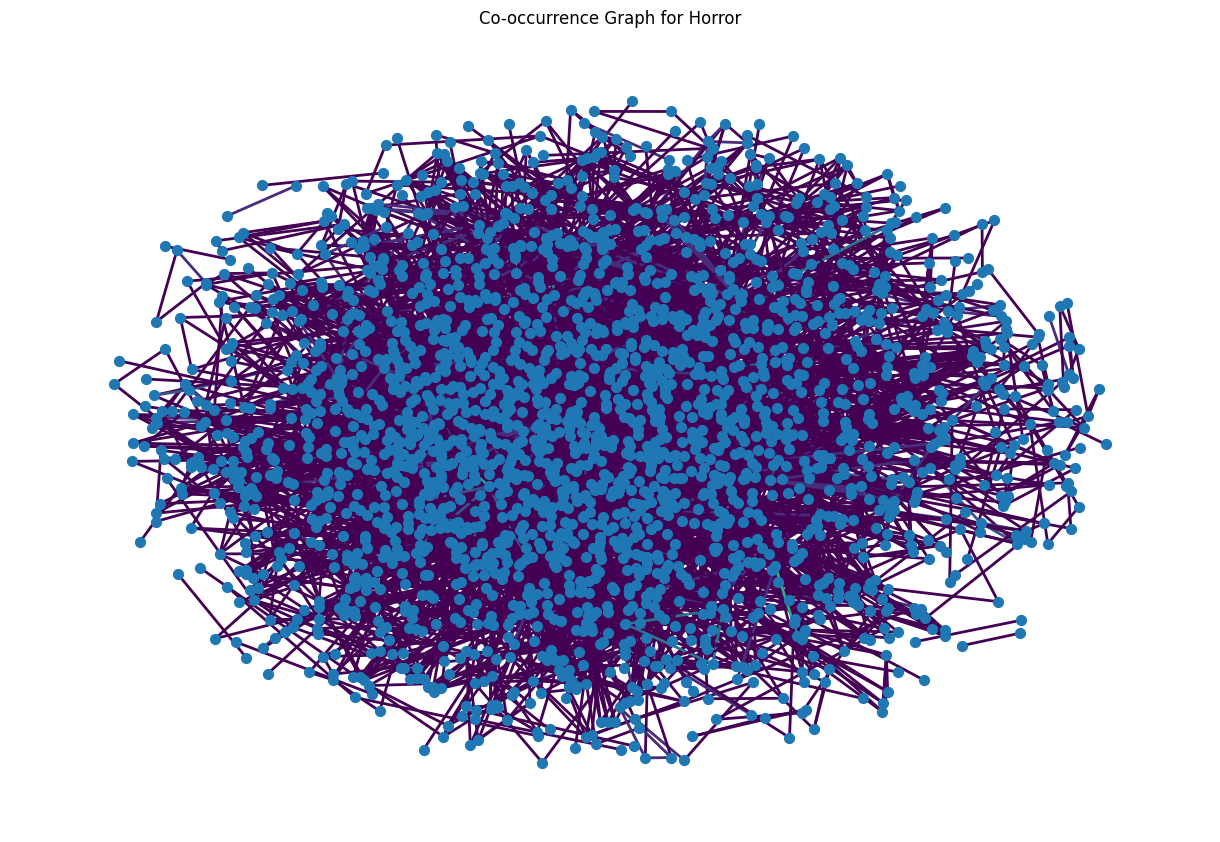

In [117]:
# Visualiser un graphe de co-occurrence
def plot_graph(graph, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.15)
    weights = nx.get_edge_attributes(graph, 'weight').values()
    nx.draw(graph, pos, node_size=50, font_size=10, edge_color=weights, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()

# Exemple de visualisation pour un genre
plot_graph(genre_graphs['Horror'], 'Co-occurrence Graph for Horror')

## Calculer les mesures de centralite du graph

In [118]:
import time

# Fonction pour calculer les mesures de centralité
def compute_centrality_measures(graphs):
    centrality_measures = defaultdict(dict)
    for genre, graph in graphs.items():
        start_time = time.time()
        print(f"Calcul des mesures de centralité pour le genre {genre}")

        centrality_measures[genre]['degree'] = nx.degree_centrality(graph)
        degree_time = time.time()
        print(f"Degree centrality done in {degree_time - start_time:.2f} seconds")

        centrality_measures[genre]['closeness'] = nx.closeness_centrality(graph)
        closeness_time = time.time()
        print(f"Closeness centrality done in {closeness_time - degree_time:.2f} seconds")

        centrality_measures[genre]['betweenness'] = nx.betweenness_centrality(graph)
        betweenness_time = time.time()
        print(f"Betweenness centrality done in {betweenness_time - closeness_time:.2f} seconds")

        try:
            centrality_measures[genre]['eigenvector'] = nx.eigenvector_centrality(graph)
            eigenvector_time = time.time()
            print(f"Eigenvector centrality done in {eigenvector_time - betweenness_time:.2f} seconds")
        except nx.PowerIterationFailedConvergence:
            print(f"Eigenvector centrality did not converge for genre {genre}")

        centrality_measures[genre]['pagerank'] = nx.pagerank(graph)
        pagerank_time = time.time()
        print(f"Pagerank centrality done in {pagerank_time - eigenvector_time:.2f} seconds")

        total_time = time.time() - start_time
        print(f"Terminé pour le genre {genre} en {total_time:.2f} seconds")

        print()
        
    return centrality_measures

# Calcul des mesures de centralité
# centrality_measures = compute_centrality_measures(genre_graphs)

In [119]:
# with open('../results/centrality_measures.pkl', 'wb') as f:
#     pickle.dump(centrality_measures, f)

with open('../results/centrality_measures.pkl', 'rb') as f:
    centrality_measures = pickle.load(f)

## Acteurs les plus centraux par genre

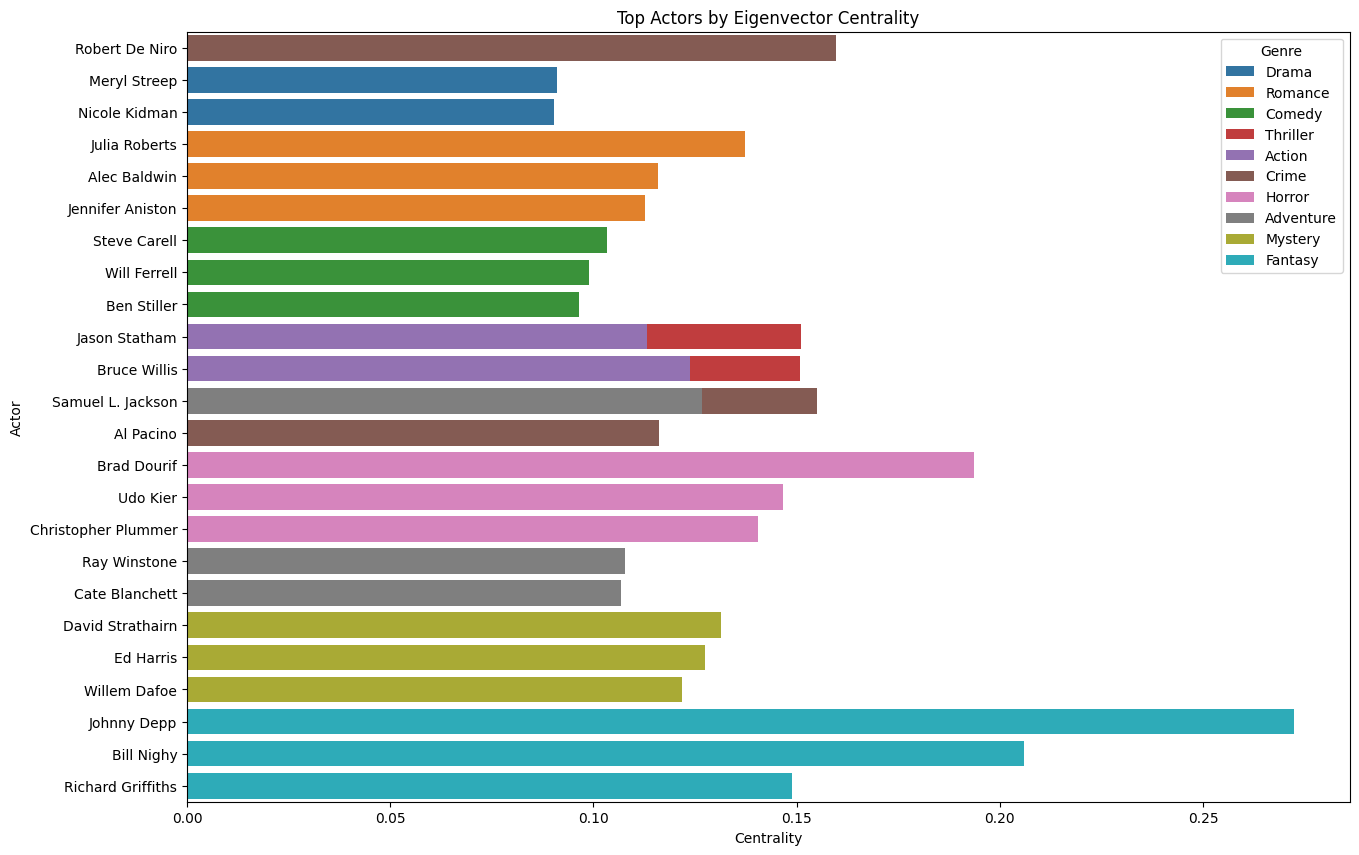

In [120]:
def get_top_central_actors(centrality_measures, names, top_n=5):
    top_actors = defaultdict(dict)
    for genre, measures in centrality_measures.items():
        for centrality_type, centrality in measures.items():
            # Trier les acteurs par centralité décroissante et prendre les top_n
            sorted_actors = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
            # Ajouter les noms des acteurs
            top_actors[genre][centrality_type] = [(actor, names[names['nconst'] == actor]['primaryName'].values[0], value) for actor, value in sorted_actors]
    return top_actors

# Obtenir les acteurs les plus centraux pour chaque genre
top_actors = get_top_central_actors(centrality_measures, names, top_n=3)

def plot_centrality_bars(top_actors, centrality_type='degree'):
    data = []
    for genre, centralities in top_actors.items():
        if centrality_type in centralities:
            for actor, name, value in centralities[centrality_type]:
                data.append([genre, name, value])
    df = pd.DataFrame(data, columns=['Genre', 'Actor', 'Centrality'])

    # Créer des graphiques de barres pour chaque genre
    plt.figure(figsize=(15, 10))
    sns.barplot(x='Centrality', y='Actor', hue='Genre', data=df, dodge=False)
    plt.title(f'Top Actors by {centrality_type.capitalize()} Centrality')
    plt.xlabel('Centrality')
    plt.ylabel('Actor')
    plt.show()

# Exemple de visualisation pour la centralité de degré
plot_centrality_bars(top_actors, centrality_type='eigenvector')
# plot_centrality_bars(top_actors, centrality_type='degree')
# plot_centrality_bars(top_actors, centrality_type='closeness')
# plot_centrality_bars(top_actors, centrality_type='betweenness')
# plot_centrality_bars(top_actors, centrality_type='pagerank')

## Calculer la correlation entre la centralite et le succes

In [121]:
# Corrélation entre centralité et succès par genre
def analyze_centrality_success_by_genre(movies, centralities_by_genre):
    correlations = {}
    
    for genre, centralities in centralities_by_genre.items():
        print(f"Analyse de la corrélation pour le genre {genre}")
        genre_movies = movies[movies['genres'].apply(lambda x: genre in x)]
        for centrality_type, centrality_scores in centralities.items():
            print(f"Analyse de la corrélation pour la centralité {centrality_type}")
            actor_scores = []
            movie_ratings = []
            
            for actor, score in centrality_scores.items():
                actor_movies = genre_movies[genre_movies['tconst'].isin(actors[actors['nconst'] == actor]['tconst'])]
                if not actor_movies.empty:
                    average_rating = actor_movies['averageRating'].mean()
                    actor_scores.append(score)
                    movie_ratings.append(average_rating)
            
            if actor_scores and movie_ratings:
                correlation = np.corrcoef(actor_scores, movie_ratings)[0, 1]
                if genre not in correlations:
                    correlations[genre] = {}
                correlations[genre][centrality_type] = correlation
    
    return correlations

# correlations_by_genre = analyze_centrality_success_by_genre(movies, centrality_measures)

In [122]:
# with open('../results/correlations_by_genre.pkl', 'wb') as f:
#     pickle.dump(correlations_by_genre, f)

with open('../results/correlations_by_genre.pkl', 'rb') as f:
    correlations_by_genre = pickle.load(f)

### Heatmap

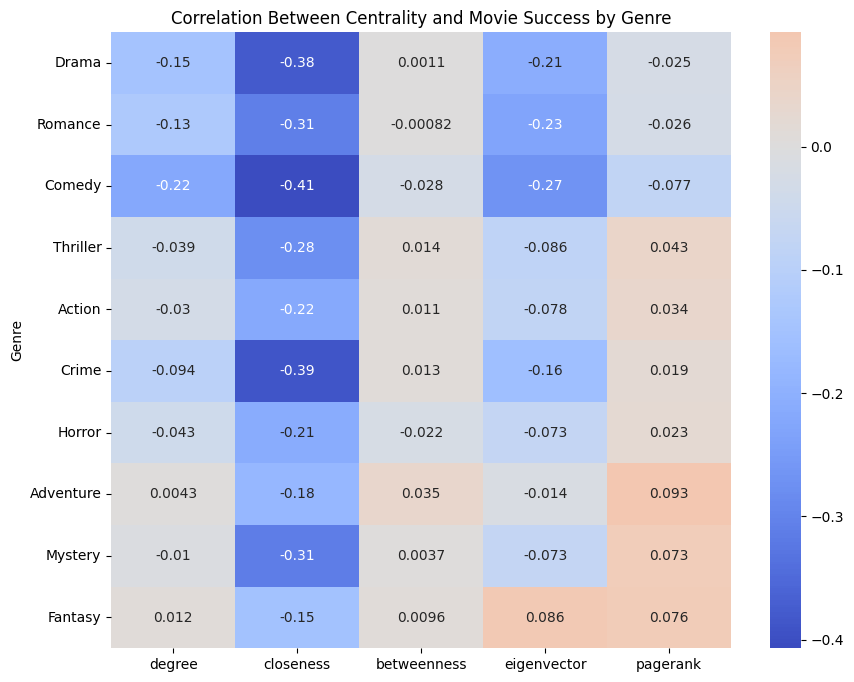

In [123]:
# Convertir les corrélations en DataFrame pour la heatmap
correlations_df = pd.DataFrame(correlations_by_genre).T

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Centrality and Movie Success by Genre')
plt.ylabel('Genre')
plt.show()

## Combiner tous les graph pour faire pareil mais pas par genre

In [124]:
# Calculer les mesures de centralité globales
def compute_global_centrality_measures(graphs):
    global_graph = nx.Graph()
    for graph in graphs.values():
        global_graph = nx.compose(global_graph, graph)
    
    centrality_measures = {
        'degree': nx.degree_centrality(global_graph),
        'closeness': nx.closeness_centrality(global_graph),
        'betweenness': nx.betweenness_centrality(global_graph),
        'eigenvector': nx.eigenvector_centrality(global_graph, max_iter=500),
        'pagerank': nx.pagerank(global_graph)
    }
    
    return centrality_measures

# Calculer les mesures de centralité globales
# global_centrality_measures = compute_global_centrality_measures(genre_graphs)

In [125]:
# with open('../results/global_centrality_measures.pkl', 'wb') as f:
#     pickle.dump(global_centrality_measures, f)

with open('../results/global_centrality_measures.pkl', 'rb') as f:
    global_centrality_measures = pickle.load(f)

In [126]:
def analyze_global_centrality_success(movies, centralities, actors):
    correlations = {}
    actor_scores = {key: [] for key in centralities.keys()}
    movie_ratings = {key: [] for key in centralities.keys()}
    
    for centrality_type, centrality_scores in centralities.items():
        print(f"Analyse de la corrélation pour la centralité {centrality_type}")
        for actor, score in centrality_scores.items():
            actor_movies = movies[movies['tconst'].isin(actors[actors['nconst'] == actor]['tconst'])]
            if not actor_movies.empty:
                average_rating = actor_movies['averageRating'].mean()
                actor_scores[centrality_type].append(score)
                movie_ratings[centrality_type].append(average_rating)
        
        if actor_scores[centrality_type] and movie_ratings[centrality_type]:
            correlation = np.corrcoef(actor_scores[centrality_type], movie_ratings[centrality_type])[0, 1]
            correlations[centrality_type] = correlation
    
    return correlations

# Analyser la corrélation globale
# global_correlations = analyze_global_centrality_success(movies, global_centrality_measures, actors)

In [127]:
# with open('../results/global_correlations.pkl', 'wb') as f:
#     pickle.dump(global_correlations, f)

with open('../results/global_correlations.pkl', 'rb') as f:
    global_correlations = pickle.load(f)

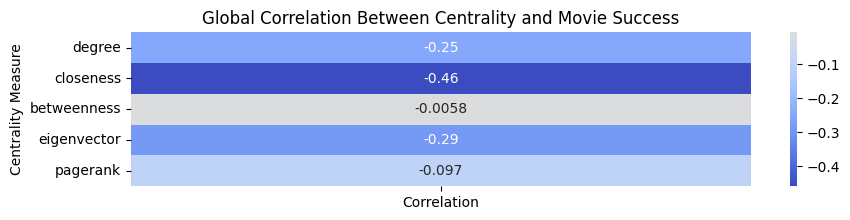

In [128]:
# Convertir les corrélations globales en DataFrame pour la heatmap
global_correlations_df = pd.DataFrame(global_correlations, index=['Correlation']).T

# Création de la heatmap globale
plt.figure(figsize=(10, 2))
sns.heatmap(global_correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Global Correlation Between Centrality and Movie Success')
plt.ylabel('Centrality Measure')
plt.show()